#  Cheapest day before a flight to buy tickets prediction - Iteration 2

In [1]:

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import math
import glob

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
import os
os.chdir("../") 
print(os.getcwd())

/Users/bobby/GitHub/Flight-Prices-Predicitons


# 📦 Data provisioning
The flights is gathered from **google flights**, using a *webscraper*. It includes data from the routes **SOF-EIN** , **EIN-SOF** , **EIN-ATH** , **ISTANBUL-AMS** , **MUNICH - NEW YORK**. The dataset includes data from **03.2025 - 12.2025**

In [3]:
csv_files = glob.glob("./datasets/iteration1/*.csv")

original_main_data = pd.concat([pd.read_csv(file, parse_dates=["departureDate", "record_timestamp"], low_memory=False) for file in csv_files], ignore_index=True)

main_data = original_main_data.copy(deep=True)


# 📃 Sample the data


In [4]:
main_data.sample(10)

,daysAgo,departureDate,price,departure_airport,arrival_airport,is_public_holiday,is_school_holiday,airline,near_holiday,record_timestamp
51104,94,2025-05-15,82,New York,"Washington, D.C.",False,False,Republic American,NaN,2025-02-10
33563,179,2025-08-25,186,İstanbul,Amsterdam,False,True,Turkish Airlines,1.0,2025-02-27
47268,210,2025-09-21,92,Eindhoven,Sofia,False,False,Wizzair,-1.0,2025-02-23
52100,90,2025-05-31,44,New York,"Washington, D.C.",False,False,Republic American,1.0,2025-03-02
1346,83,2025-04-16,143,Eindhoven,Athens,False,False,Aegean,-1.0,2025-01-23
40423,111,2025-06-01,63,Eindhoven,Sofia,False,False,Ryanair,NaN,2025-02-10
23117,210,2025-09-20,142,Sofia,Eindhoven,False,False,Wizzair,-1.0,2025-02-22
57559,221,2025-08-31,91,New York,"Washington, D.C.",False,True,Delta,1.0,2025-01-22
1562,53,2025-04-19,148,Eindhoven,Athens,True,False,Other,-1.0,2025-02-25
31209,141,2025-07-18,88,İstanbul,Amsterdam,False,True,Turkish Airlines,1.0,2025-02-27


# 🛠️ Preprocessing 

The step of preprocessing contains several activities to consider before we can start training the algorithm and produce a model that can predict our target variable, in this case the days before a flight, containing the cheapest tickets. 

In [5]:
print("Missing values per column:")
print(main_data.isna().sum())

Missing values per column:
daysAgo                  0
departureDate            0
price                    0
departure_airport        0
arrival_airport          0
is_public_holiday        0
is_school_holiday        0
airline                  0
near_holiday         15941
record_timestamp         0
dtype: int64


We can see that half of our data, 15k/30k has missing values on near_holiday. This is to be expected.

## Adding new feature - distance between departure and arrival airports

In [6]:
airport_coords = {
    'New York': (40.7128, -74.0060),
    'Amsterdam': (52.3676, 4.9041),
    'Athens': (37.9838, 23.7275),
    'Eindhoven': (51.4416, 5.4697),
    'Sofia': (42.6975, 23.3242),
    'Washington, D.C.': (38.8951, -77.0364),
    'İstanbul': (41.0082, 28.9784)
}

# Function to calculate Haversine distance
# Source: https://stackoverflow.com/questions/25711895/the-result-by-haversine-formula-is-meter-o-kmeter
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in km
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2.0) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c  # Distance in km

def calculate_distance(row):
    dep = row['departure_airport']
    arr = row['arrival_airport']
    if dep in airport_coords and arr in airport_coords:
        lat1, lon1 = airport_coords[dep]
        lat2, lon2 = airport_coords[arr]
        return haversine_distance(lat1, lon1, lat2, lon2)
    else:
        return None  # Handle missing airport coordinates

main_data['airport_distance_km'] = main_data.apply(calculate_distance, axis=1)
main_data.sample(10)

,daysAgo,departureDate,price,departure_airport,arrival_airport,is_public_holiday,is_school_holiday,airline,near_holiday,record_timestamp,airport_distance_km
23584,239,2025-09-28,110,Sofia,Eindhoven,False,False,Wizzair,1.0,2025-02-01,1658.335311
15759,66,2025-05-22,59,Sofia,Eindhoven,False,False,Wizzair,-1.0,2025-03-17,1658.335311
32581,155,2025-08-09,181,İstanbul,Amsterdam,False,True,Turkish Airlines,1.0,2025-03-07,2211.947562
47151,203,2025-09-19,85,Eindhoven,Sofia,False,False,Wizzair,-1.0,2025-02-28,1658.335311
30523,138,2025-07-07,61,İstanbul,Amsterdam,False,True,Pegasus,-1.0,2025-02-19,2211.947562
59778,234,2025-10-06,67,New York,"Washington, D.C.",False,False,Delta,-1.0,2025-02-14,328.393017
30381,154,2025-07-05,79,İstanbul,Amsterdam,False,True,Other,-1.0,2025-02-01,2211.947562
54662,132,2025-07-12,76,New York,"Washington, D.C.",False,True,Delta,-1.0,2025-03-02,328.393017
38532,80,2025-05-01,115,Eindhoven,Sofia,True,True,Wizzair,-1.0,2025-02-10,1658.335311
44114,140,2025-07-31,150,Eindhoven,Sofia,False,True,Wizzair,-1.0,2025-03-13,1658.335311


In [7]:
# Feature engineering
main_data['departure_date_unix'] = main_data['departureDate'].astype(np.int64) // 10**9
main_data['record_timestamp_unix'] = main_data['record_timestamp'].astype(np.int64) // 10**9
main_data = pd.get_dummies(main_data, columns=['near_holiday']) # as the columns is -1, 0, 1 which messes with the algorithm
main_data['departure_weekday'] = main_data['departureDate'].dt.weekday

# Encode categorical variables
le_dep = LabelEncoder()
le_arr = LabelEncoder()
le_airline = LabelEncoder()
main_data['airline'] = le_airline.fit_transform(main_data['airline'])
main_data['departure_airport'] = le_dep.fit_transform(main_data['departure_airport'])
main_data['arrival_airport'] = le_arr.fit_transform(main_data['arrival_airport'])


## Marking the cheapest price for each flight

In [8]:
# Step 1: Group and find the cheapest record for each flight
cheapest_rows = main_data.loc[main_data.groupby(
    ['departureDate', 'departure_airport', 'arrival_airport']
)['price'].idxmin()] #Return the row label of the minimum value

# Step 2: Create a mapping from flight to its cheapest daysAgo
cheapest_map = cheapest_rows.set_index(
    ['departureDate', 'departure_airport', 'arrival_airport']
)['daysAgo'].to_dict()

# Step 3: Map it back to the full data
main_data['cheapest_day_future'] = main_data.apply(
    lambda row: cheapest_map.get((row['departureDate'], row['departure_airport'], row['arrival_airport'])),
    axis=1
)

# Drop rows where mapping failed (e.g. missing future prices)
main_data.dropna(subset=['cheapest_day_future'], inplace=True)
main_data['cheapest_day_future'] = main_data['cheapest_day_future'].astype(int)

### 💡 Feature Selection

Now we will create several graphs to visualize relationships between the features of the dataset


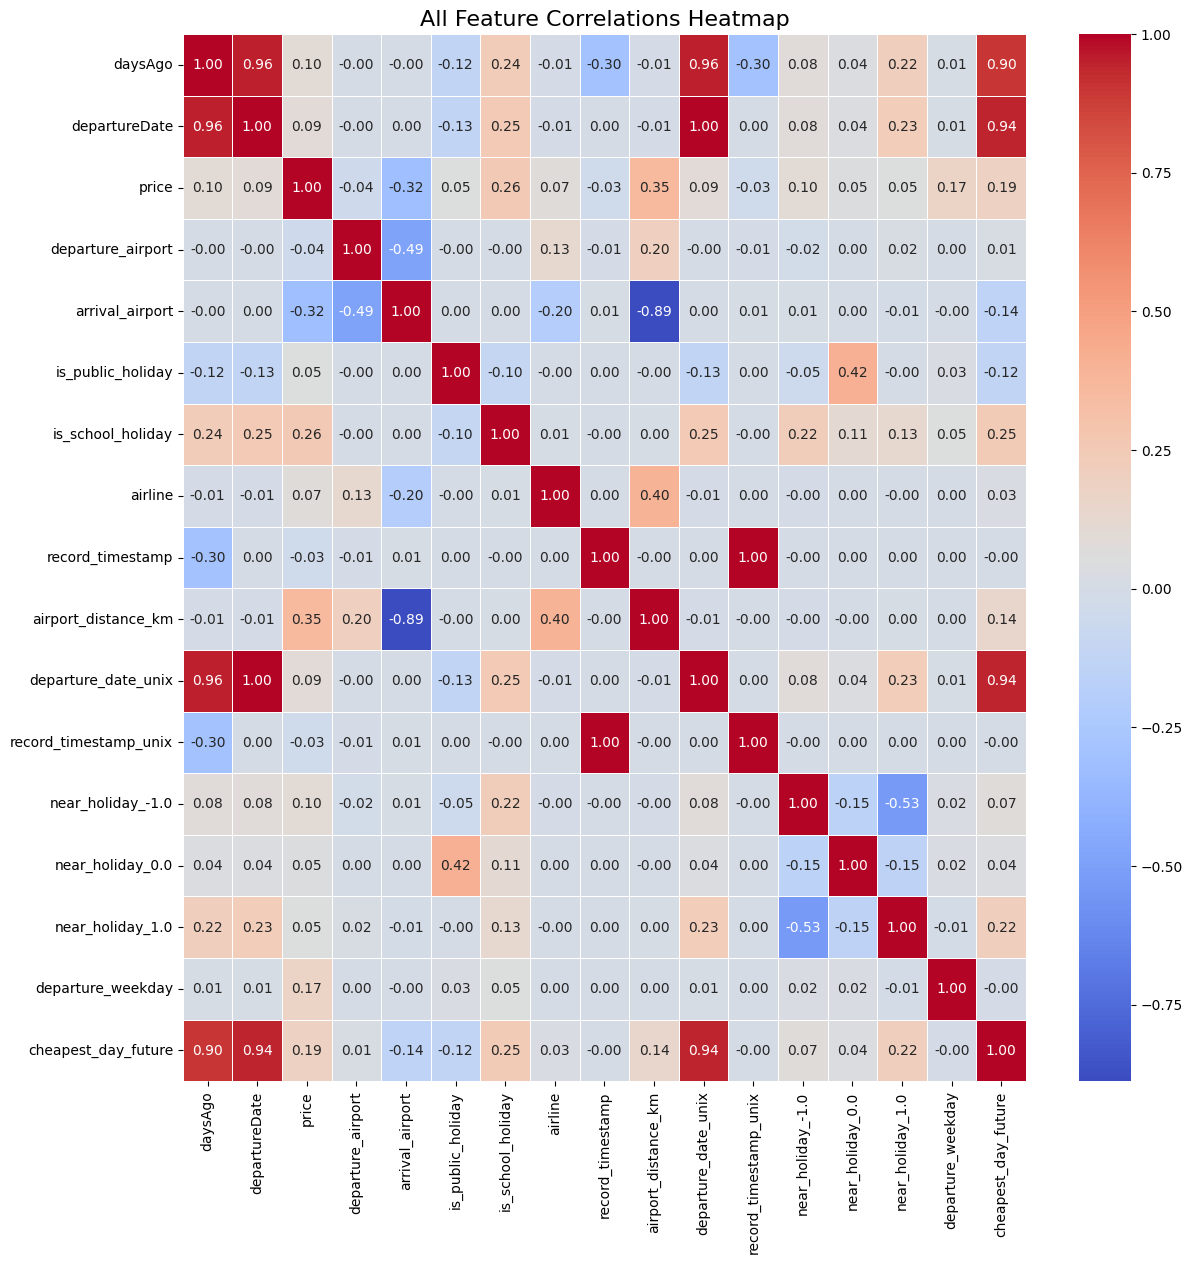

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

correlations = main_data.corr()

plt.figure(figsize=(min(20, 0.8 * len(correlations)), min(20, 0.8 * len(correlations))))  

sns.heatmap(
    correlations, 
    annot=True, 
    fmt=".2f",
    linewidths=0.5,
    cmap="coolwarm",
)

plt.title("All Feature Correlations Heatmap", fontsize=16)
plt.show()

In [10]:
correlation_target = main_data.corr()['cheapest_day_future'].sort_values(ascending=False)
print(correlation_target)

cheapest_day_future      1.000000
departure_date_unix      0.943693
departureDate            0.943693
daysAgo                  0.901768
is_school_holiday        0.245841
near_holiday_1.0         0.217296
price                    0.187732
airport_distance_km      0.142290
near_holiday_-1.0        0.073063
near_holiday_0.0         0.040271
airline                  0.026380
departure_airport        0.011745
record_timestamp        -0.000653
record_timestamp_unix   -0.000653
departure_weekday       -0.004502
is_public_holiday       -0.123838
arrival_airport         -0.142831
Name: cheapest_day_future, dtype: float64


The features most correlated with cheapest_day_future are daysAgo, departure_date_unix, and record_timestamp_unix, indicating that time-related variables play the biggest role in predicting the cheapest booking day. Other features like airport_distance_km, near_holiday flags, and airline have low correlation and may contribute little predictive power individually.

# Select features and target

In [11]:

features = [
    'price', 'airport_distance_km',
    'near_holiday_-1.0', 'near_holiday_0.0', 'near_holiday_1.0',
    'departure_airport', 'arrival_airport',
    'daysAgo', 'departure_date_unix', 'departure_weekday'
]

target = 'cheapest_day_future'

X = main_data[features]
y = main_data[target]

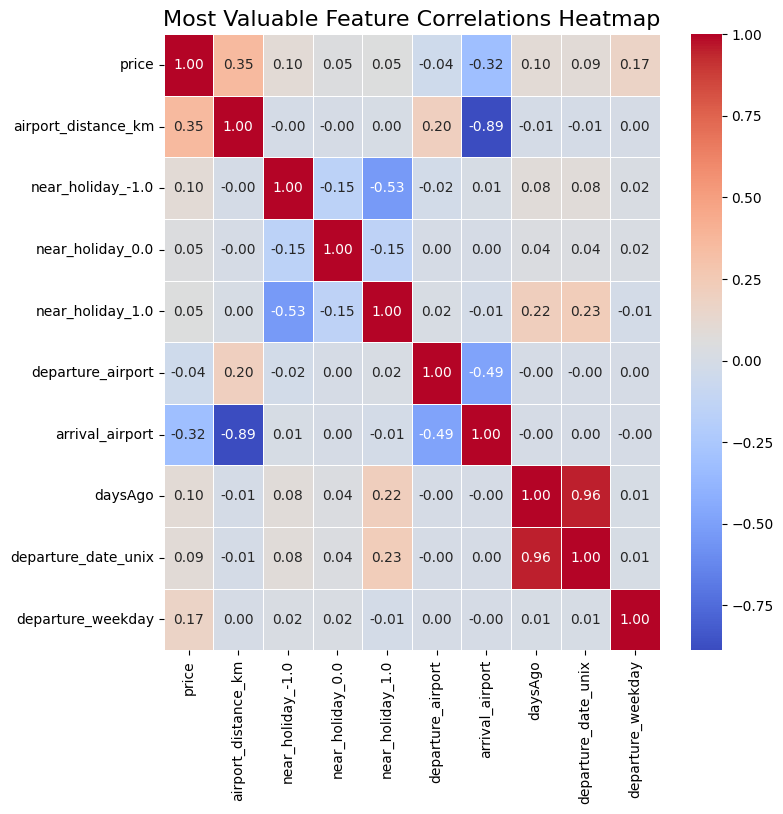

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

correlations = main_data[features].corr()

plt.figure(figsize=(min(20, 0.8 * len(correlations)), min(20, 0.8 * len(correlations))))  

sns.heatmap(
    correlations, 
    annot=True, 
    fmt=".2f",
    linewidths=0.5,
    cmap="coolwarm",
)

plt.title("Most Valuable Feature Correlations Heatmap", fontsize=16)
plt.show()

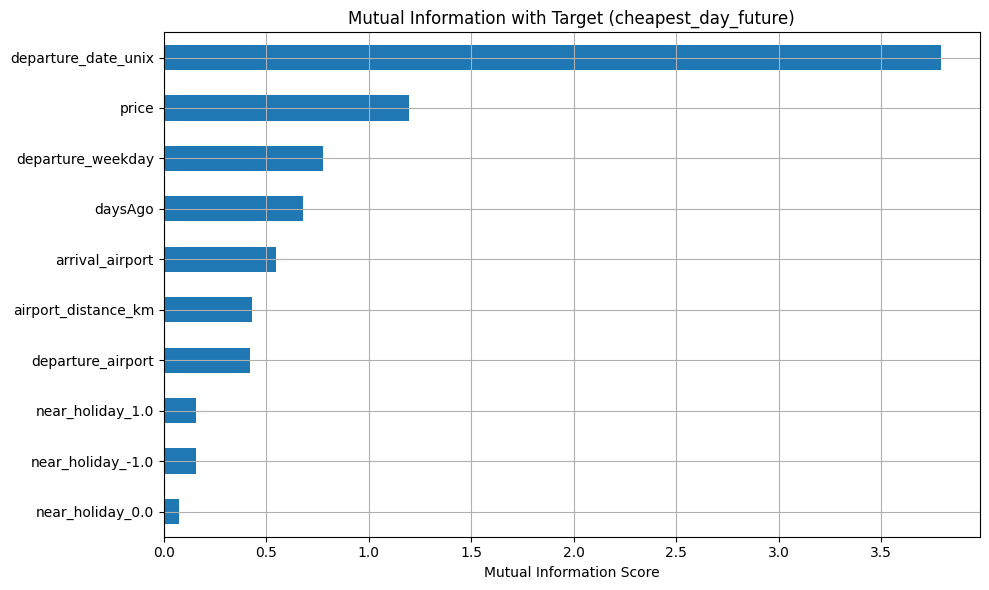

In [13]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder

# Encode any categorical columns (if not already encoded)
X_encoded = X.copy()
for col in X_encoded.select_dtypes(include='object').columns:
    X_encoded[col] = LabelEncoder().fit_transform(X_encoded[col])

# Calculate mutual information ("amount of information" obtained about one random variable by observing the other random variable)
mi_scores = mutual_info_regression(X_encoded, y)
mi_series = pd.Series(mi_scores, index=X_encoded.columns).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
mi_series.plot(kind='barh')
plt.title('Mutual Information with Target (cheapest_day_future)')
plt.xlabel('Mutual Information Score')
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

# 🪓 Splitting into train/test
80% of the data is used for training, and 20% for testing

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

There are in total 59996 observations, of which 47996 are now in the train set, and 12000 in the test set.


# 🧬 Modelling

## Previously used algorhitm Linear Regression

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

Adding the last learned algorhitm RandomForestRegression to compare the algorhitms

In [16]:

rfr = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rfr.fit(X_train, y_train)
rfr_pred = rfr.predict(X_test)

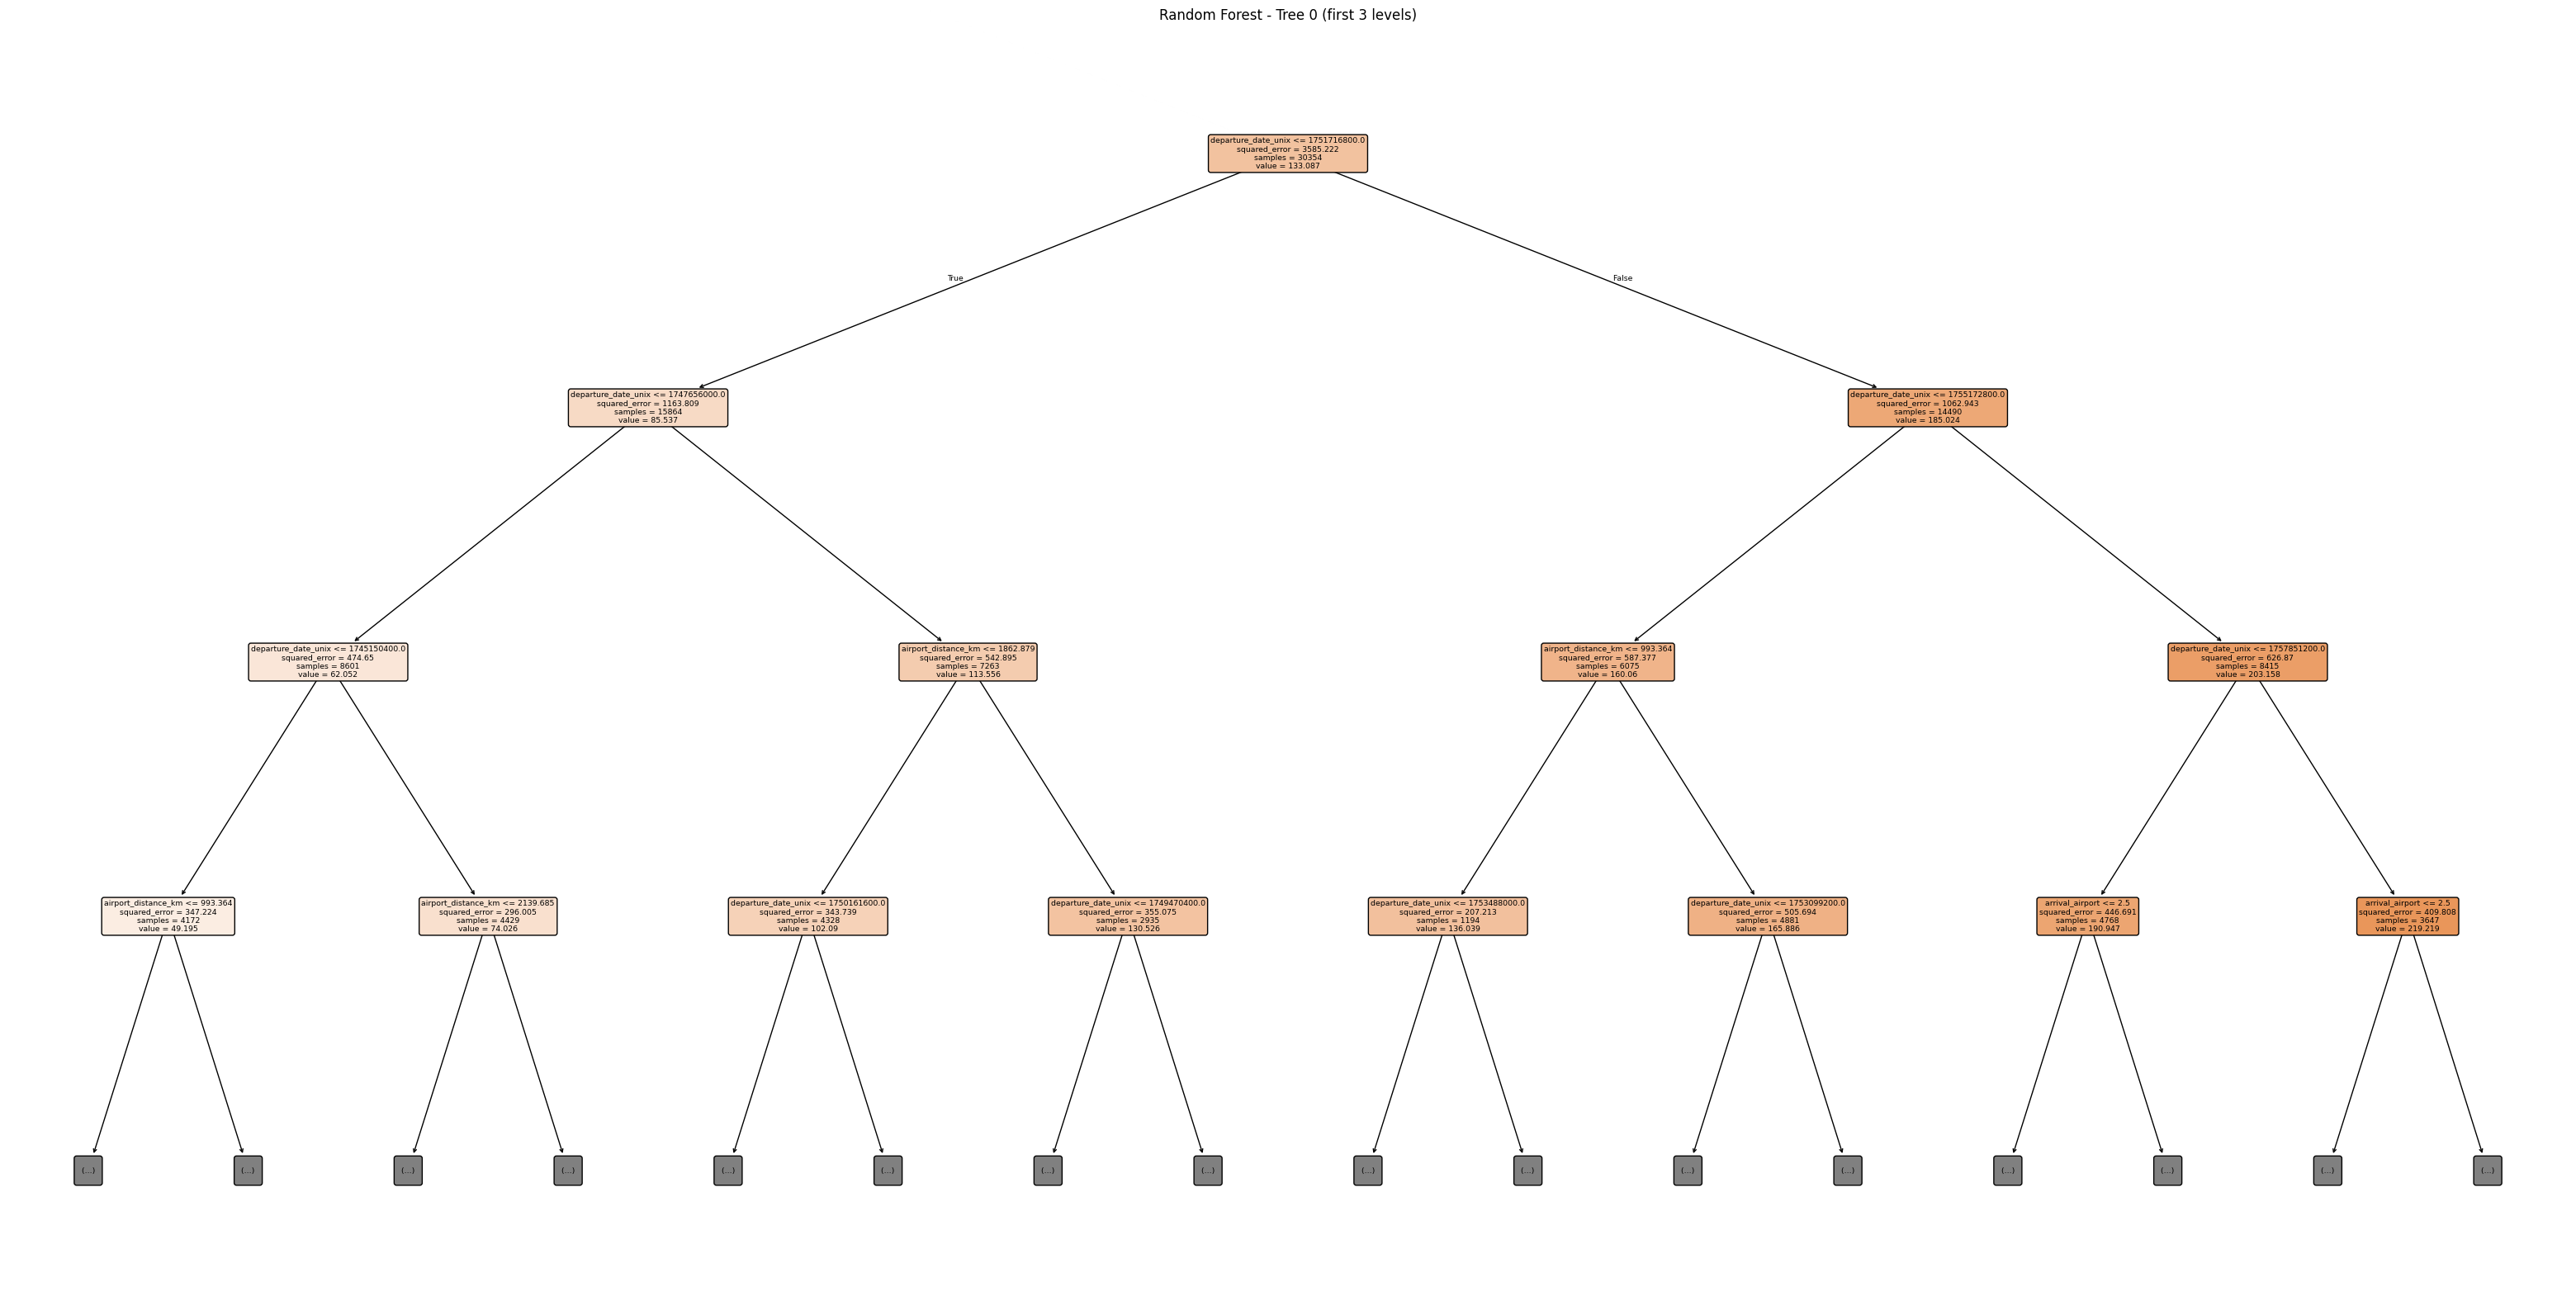

In [17]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

tree = rfr.estimators_[0] 

plt.figure(figsize=(40, 20))
plot_tree(tree, feature_names=X.columns, filled=True, rounded=True, max_depth=3)
plt.title("Random Forest - Tree 0 (first 3 levels)")
plt.show()

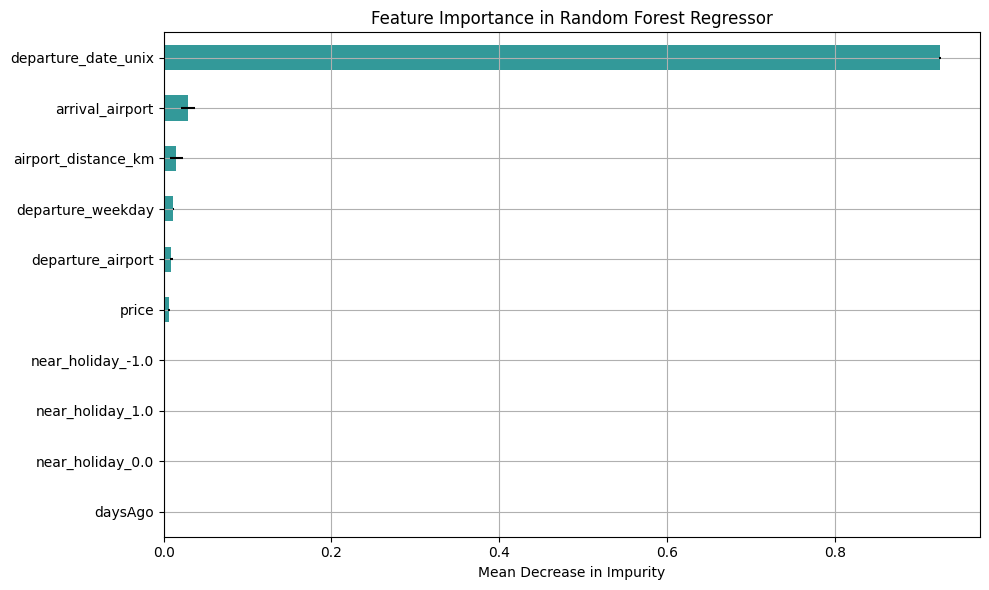

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assume your model is called `reg` and your features are in a list `features`
features = X.columns  # or manually define the list of feature names

# Get feature importances
importances = pd.Series(rfr.feature_importances_, index=features)

# Get standard deviation across all decision trees
std_dev = np.std([tree.feature_importances_ for tree in rfr.estimators_], axis=0)

# Plot
plt.figure(figsize=(10, 6))
importances.sort_values().plot.barh(xerr=std_dev[np.argsort(importances)], color='teal', alpha=0.8)
plt.title("Feature Importance in Random Forest Regressor")
plt.xlabel("Mean Decrease in Impurity")
plt.tight_layout()
plt.grid(True)
plt.show()

# 🔬 Evaluation
In order to shed some light on the results a classification report can be printed. 

In [19]:
# Calculate evaluation metrics
r2_lr = r2_score(y_test, lr_pred)
r2_rfr = r2_score(y_test, rfr_pred)

print(f"R² Score LR: {r2_lr}")
print(f"R² Score RFR: {r2_rfr}")

# Round to the 3 closest integers
top3_preds = [np.round([pred - 1, pred, pred + 1]).astype(int) for pred in rfr_pred]
# Check if actual is in top 3
top3_match = [y_test.iloc[i] in top3_preds[i] for i in range(len(y_test))]
top3_accuracy = np.mean(top3_match)
print(f"Top-3 Regression Accuracy: {top3_accuracy:.2%}")

R² Score LR: 0.9169942992949056
R² Score RFR: 0.9900211870720809
Top-3 Regression Accuracy: 49.79%


The random forest give a very nice accuracy result, ill try to use boosting to improve the score for the Linear Regression

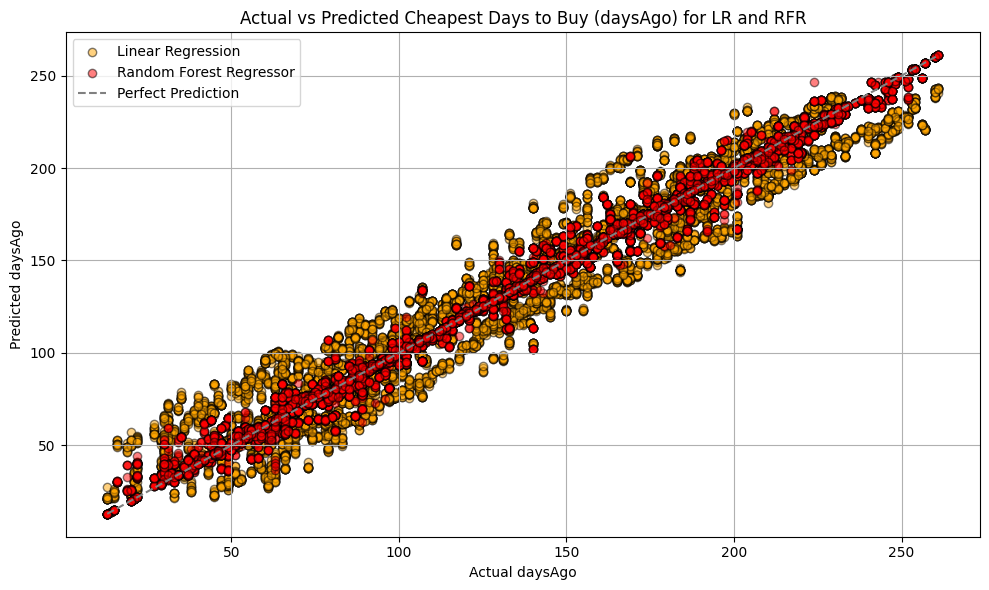

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Scatter plot: Actual vs Predicted
plt.scatter(y_test, lr_pred, alpha=0.5, color='orange', edgecolors='k', label='Linear Regression')
plt.scatter(y_test, rfr_pred, alpha=0.5, color='red', edgecolors='k', label='Random Forest Regressor')

# Add a reference line (perfect predictions)
min_val = min(min(y_test), min(lr_pred), min(rfr_pred))
max_val = max(max(y_test), max(lr_pred), max(rfr_pred))
plt.plot([min_val, max_val], [min_val, max_val], color='gray', linestyle='--', label='Perfect Prediction')

# Labels, title, legend
plt.xlabel('Actual daysAgo')
plt.ylabel('Predicted daysAgo')
plt.title('Actual vs Predicted Cheapest Days to Buy (daysAgo) for LR and RFR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The scatter plot shows that the Random Forest Regressor makes predictions much closer to the actual values compared to Linear Regression, especially for higher daysAgo values. This indicates that Random Forest captures the complex patterns in flight pricing better, making it the more accurate model.

In [21]:
import pandas as pd

comparison_df = pd.DataFrame({
    'Actual': y_test.reset_index(drop=True)[:20],
    'Linear Regression': lr_pred[:20].round(2),
    'Random Forest': rfr_pred[:20].round(2),
})

# Add residuals
comparison_df['LR Residual'] = (comparison_df['Actual'] - comparison_df['Linear Regression']).round(2)
comparison_df['RFR Residual'] = (comparison_df['Actual'] - comparison_df['Random Forest']).round(2)

# Display
print(comparison_df)

    Actual  Linear Regression  Random Forest  LR Residual  RFR Residual
0      210             199.34         208.72        10.66          1.28
1      207             186.44         206.45        20.56          0.55
2      249             230.90         249.00        18.10          0.00
3      184             171.18         184.60        12.82         -0.60
4      202             212.15         202.09       -10.15         -0.09
5      180             151.23         180.02        28.77         -0.02
6      159             158.98         158.83         0.02          0.17
7      190             188.35         190.14         1.65         -0.14
8      215             190.93         210.02        24.07          4.98
9       42              44.69          41.96        -2.69          0.04
10      85              85.82          80.42        -0.82          4.58
11     165             139.19         152.92        25.81         12.08
12     192             188.45         203.15         3.55       

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

def compare_lr_vs_rf(X_train, X_test, y_train, y_test, max_depth=None):
    rf_train_scores, rf_test_scores = [], []
    lr_train_scores, lr_test_scores = [], []

    estimators_range = range(10, 211, 20)

    for n in estimators_range:
        # === Random Forest Regressor ===
        rf = RandomForestRegressor(n_estimators=n, max_depth=max_depth, random_state=21, n_jobs=-1)
        rf.fit(X_train, y_train)
        rf_train_scores.append(rf.score(X_train, y_train))
        rf_test_scores.append(rf.score(X_test, y_test))

        # === Linear Regression (same every time) ===
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        lr_train_scores.append(lr.score(X_train, y_train))
        lr_test_scores.append(lr.score(X_test, y_test))

    # === Plot Results ===
    plt.figure(figsize=(12, 6))

    # Random Forest
    plt.plot(estimators_range, rf_train_scores, marker='o', linestyle='--', label=f'RF Train (max_depth={max_depth})', linewidth=2)
    plt.plot(estimators_range, rf_test_scores, marker='o', label=f'RF Test (max_depth={max_depth})', linewidth=2)

    # Linear Regression (flat line)
    plt.plot(estimators_range, lr_train_scores, marker='s', linestyle='--', label='LR Train (constant)', linewidth=2)
    plt.plot(estimators_range, lr_test_scores, marker='s', label='LR Test (constant)', linewidth=2)

    plt.xlabel('Number of Estimators (for RF only)')
    plt.ylabel('R² Score')
    plt.title('Train vs Test: Random Forest vs Linear Regression')
    plt.grid(True)
    plt.xlim(estimators_range[0], estimators_range[-1])
    plt.legend()
    plt.tight_layout()
    plt.show()

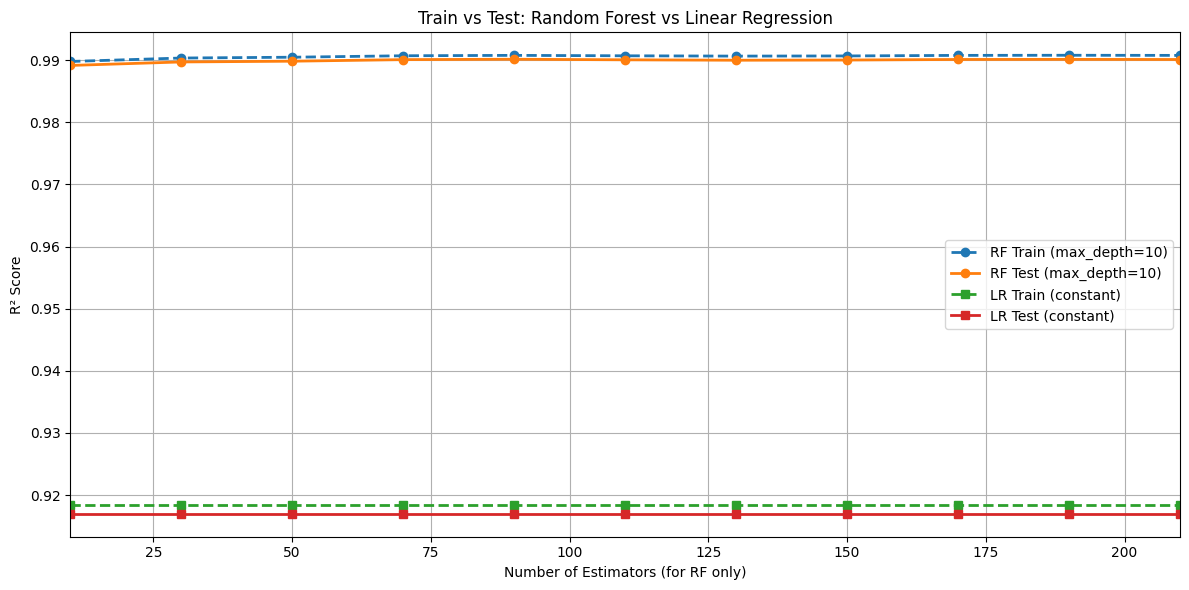

In [23]:
compare_lr_vs_rf(X_train, X_test, y_train, y_test, max_depth=10)

Random Forest (max_depth=10):
-	Train R² ≈ 0.990–0.992, very high — suggesting near-perfect fit on training data.
-	Test R² ≈ 0.989–0.990, almost identical to train — indicating no overfitting and strong generalization.
-	Increasing the number of estimators improves consistency but brings minimal gain after ~50 estimators.

Linear Regression:
-	Flat performance across all points (as expected, since it’s not affected by n_estimators).
-	Train & Test R² ≈ 0.918, consistently lower than Random Forest, meaning it underfits slightly and misses non-linear patterns in the data.

# Inference

In [26]:
# Example user input
from datetime import datetime
import time

departure_date = datetime(2025, 8, 31)
record_date = datetime(2025, 4, 25)
daysAgo_input = (departure_date - record_date).days

sample_input = pd.DataFrame([{
    'price': 208,
    'airport_distance_km': 2000,
    'near_holiday_-1.0': 0,
    'near_holiday_0.0': 0,
    'near_holiday_1.0': 0,
    'departure_airport': le_dep.transform(['Sofia'])[0],
    'arrival_airport': le_arr.transform(['Eindhoven'])[0],
    'daysAgo': daysAgo_input,
    'departure_date_unix': int(time.mktime(departure_date.timetuple())),
    'departure_weekday': departure_date.weekday()
}])

user_input = sample_input[features]
user_pred = rfr.predict(user_input)[0]
top3_user_preds = np.round([user_pred - 1, user_pred, user_pred + 1]).astype(int)

print("Top 3 estimated best days before departure to buy:")
print(top3_user_preds)

Top 3 estimated best days before departure to buy:
[203 204 205]


----------

The algorhitms seems to perform well enough to call the project a success!

In [25]:
import joblib

# Save your classifier
joblib.dump(rfr, './flight_model.pkl')

# Save encoders if needed
joblib.dump(le_dep, './departure_encoder.pkl')
joblib.dump(le_arr, './arrival_encoder.pkl')

['./arrival_encoder.pkl']

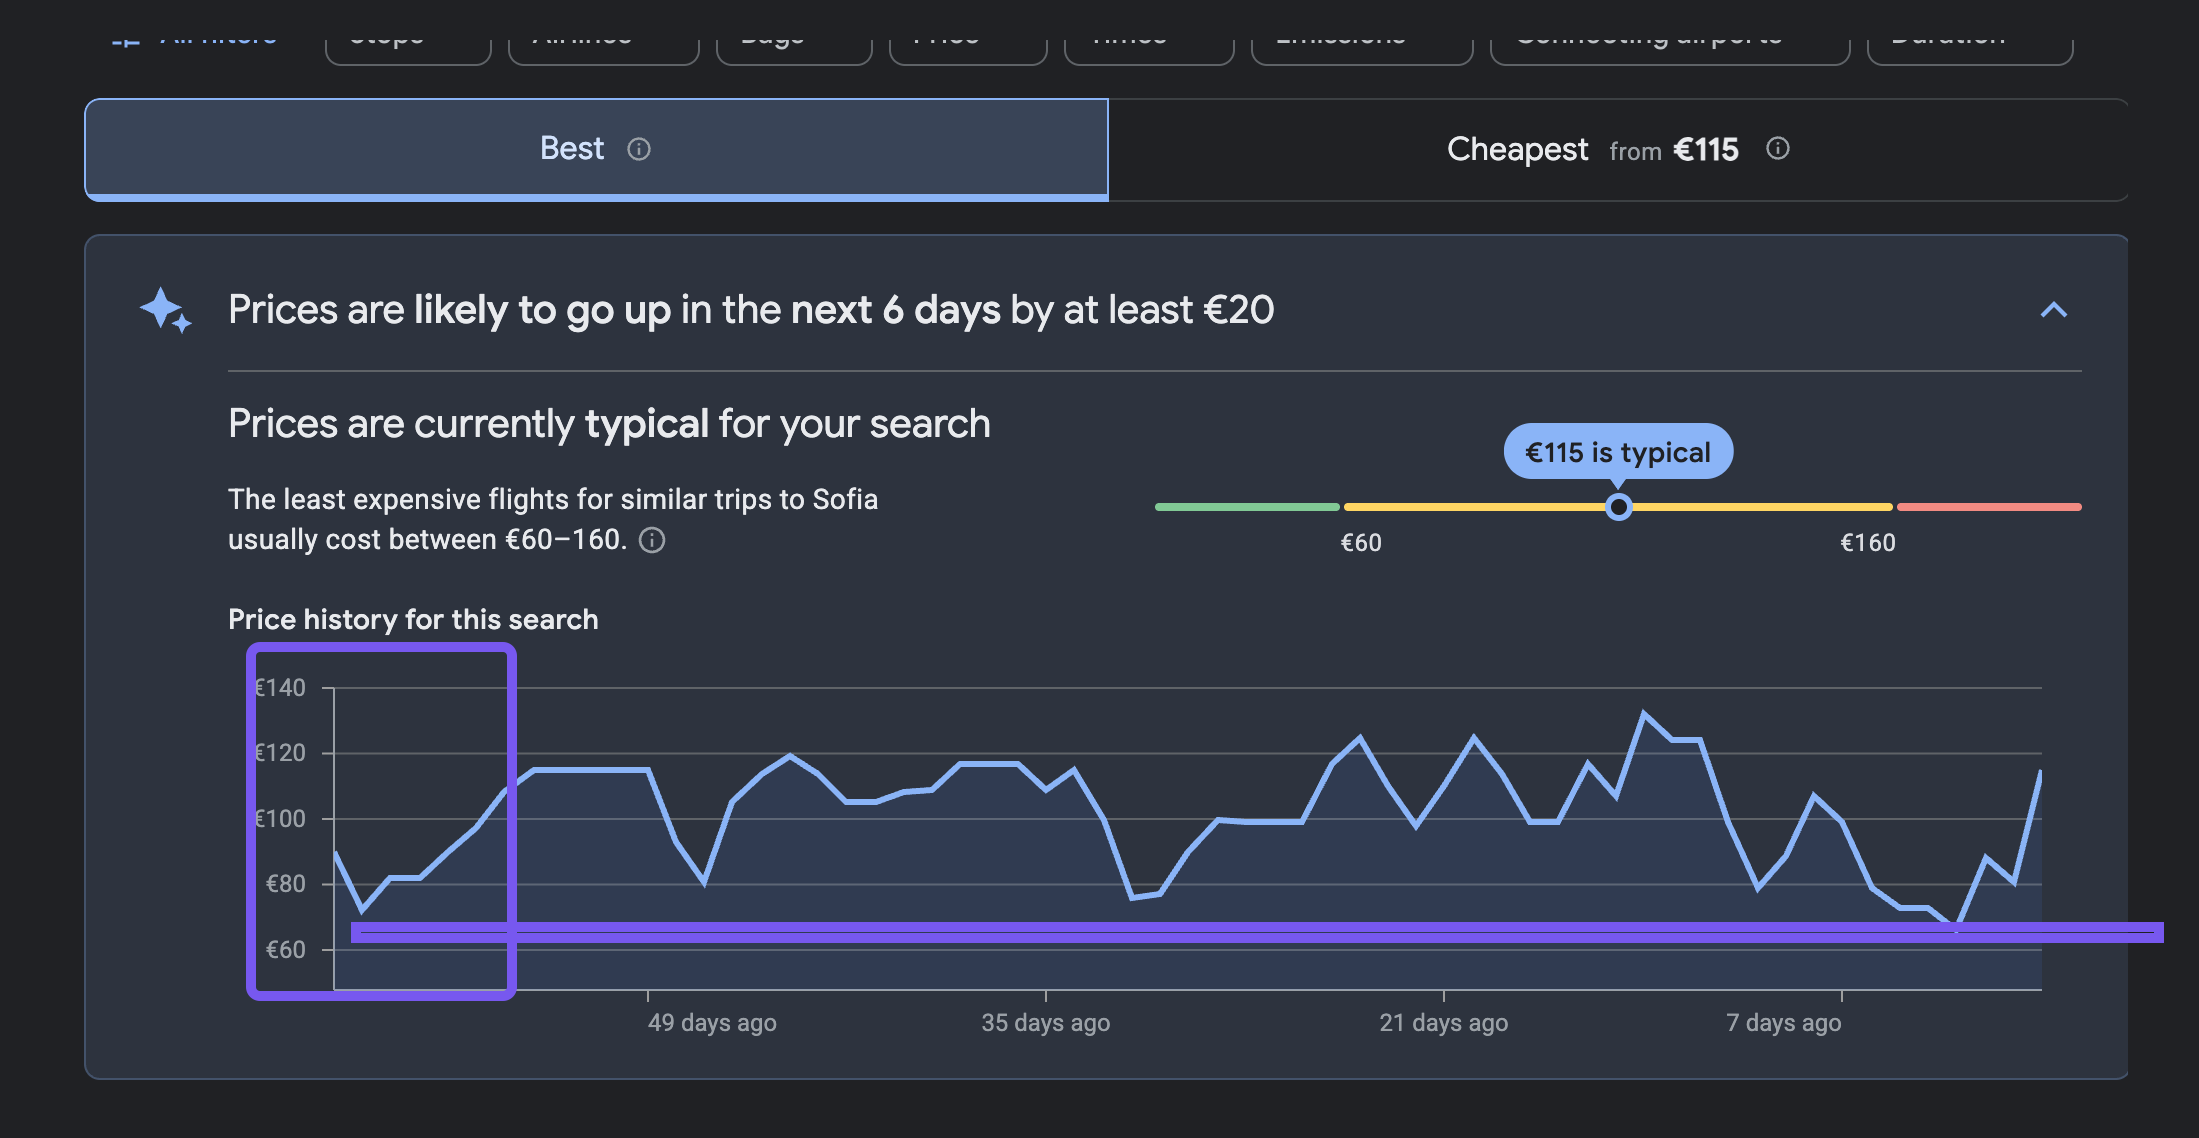

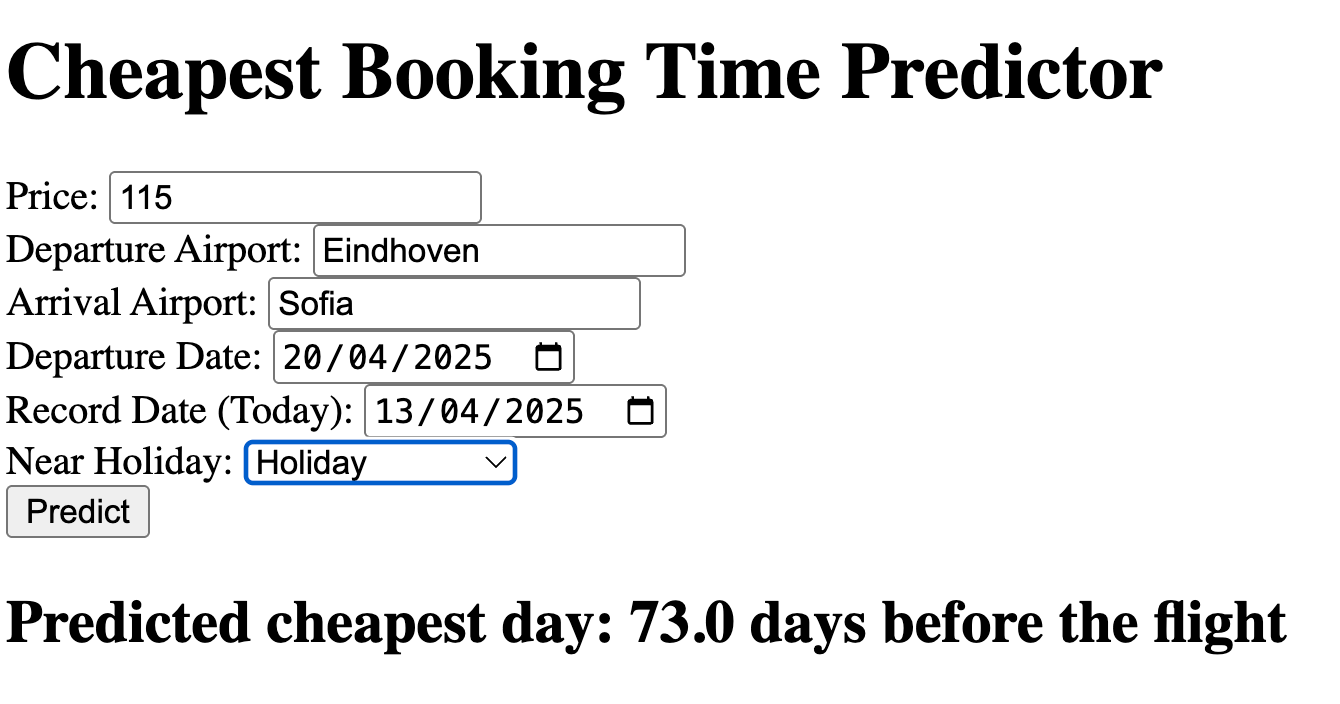

## ✈️ Summary – Iteration 2

In this iteration, the project improved both the data and the model:

- Added time-based features (Unix timestamps) and airport distances.
- Confirmed that time-related features (`daysAgo`, `departure_date_unix`) are the most predictive.
- Switched from Linear Regression to Random Forest Regression for better performance.

## ✅ Conclusion

Random Forest showed excellent accuracy (R² ≈ 0.99), outperforming Linear Regression. It captured non-linear pricing trends effectively and generalized well. These results validate the model and confirm that it can predict the best day to buy a flight ticket. Future steps could include tuning or testing boosting models for further improvement.